In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
from sklearn.preprocessing import StandardScaler

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import os
from PIL import Image


In [6]:
dataset_folder = '/content/drive/MyDrive/Tyre Quality'
img_path = '/content/drive/MyDrive/Tyre Quality/training/defective/Defective (1).jpg'
training_dataset_path = '/content/drive/MyDrive/Tyre Quality/training'
testing_dataset_path = '/content/drive/MyDrive/Tyre Quality/testing'
classes = sorted(os.listdir(dataset_folder + '/training'))

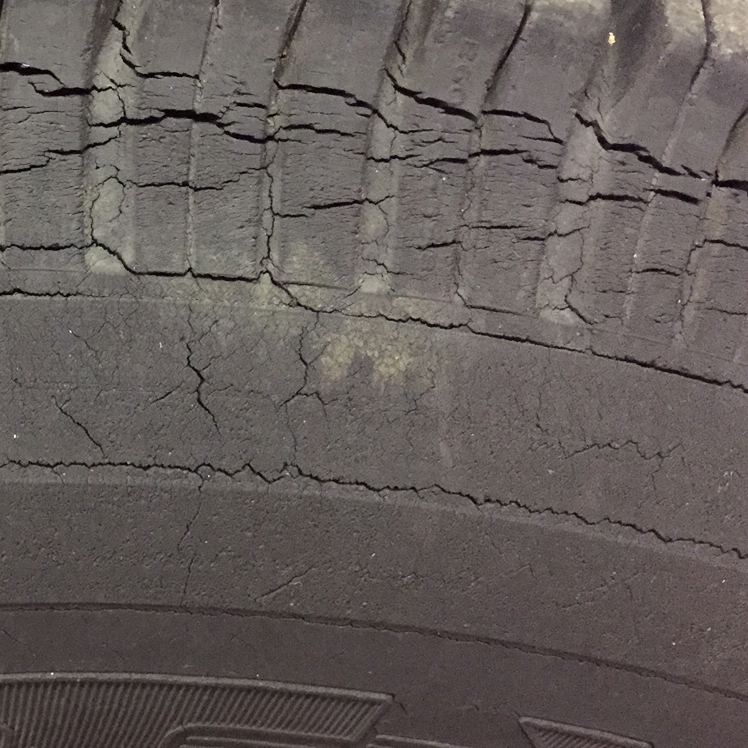

In [7]:
img = Image.open(img_path)
img

In [8]:
import numpy as np

In [9]:
classes


['defective', 'good']

In [10]:
np.random.seed(0)
torch.manual_seed(0)

In [11]:
from PIL import ImageOps, ImageFilter
import torchvision.transforms.functional as F
from torchvision import transforms

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224 pixels
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [13]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [14]:
# Load dataset
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Tyre Quality/training', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Tyre Quality/testing', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [15]:
from torchvision import models
import torch.nn as nn

In [18]:
import torch.nn.functional as F
from torchvision import models
from torch import nn
import torch

# Load the pretrained MobileNet model and remove the classifier layer for feature extraction
model = models.mobilenet_v2(pretrained=True)
features_extractor = nn.Sequential(*list(mobilenet.children())[:-1])  # Remove the classifier

# Updated feature extraction function with adaptive pooling
def extract_features(loader, model, output_size=(7, 7)):
    features_list = []
    with torch.no_grad():
        for images, _ in loader:
            # Pass the images through the MobileNet model to get the features
            features = model(images)
            # Apply adaptive pooling to standardize the feature map size
            pooled_features = F.adaptive_avg_pool2d(features, output_size)
            # Flatten the features and convert to numpy
            features_list.append(pooled_features.view(pooled_features.size(0), -1).cpu().numpy())
    return features_list


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer, only update the parameters that require gradients
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [20]:
import torch

def extract_features(loader, model, device):
    model.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            # Forward pass through the feature extractor
            features = model(inputs)
            features = features.view(features.size(0), -1)  # Flatten the features
            features_list.append(features.cpu())
            labels_list.append(labels)
    features = torch.cat(features_list)
    labels = torch.cat(labels_list)
    return features, labels

In [21]:
import torch.nn as nn

# Remove the final fully connected layer for feature extraction
feature_extractor = nn.Sequential(*list(model.children())[:-1])

In [22]:
# Assuming your model is on the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)

# Extract features for the training and validation sets
train_features, train_labels = extract_features(train_loader, feature_extractor, device)
val_features, val_labels = extract_features(val_loader, feature_extractor, device)

In [23]:
import numpy as np

# Convert to numpy arrays for easier saving and processing
train_features = train_features.numpy()
train_labels = train_labels.numpy()
val_features = val_features.numpy()
val_labels = val_labels.numpy()

# Save features and labels
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels)
np.save('val_features.npy', val_features)
np.save('val_labels.npy', val_labels)

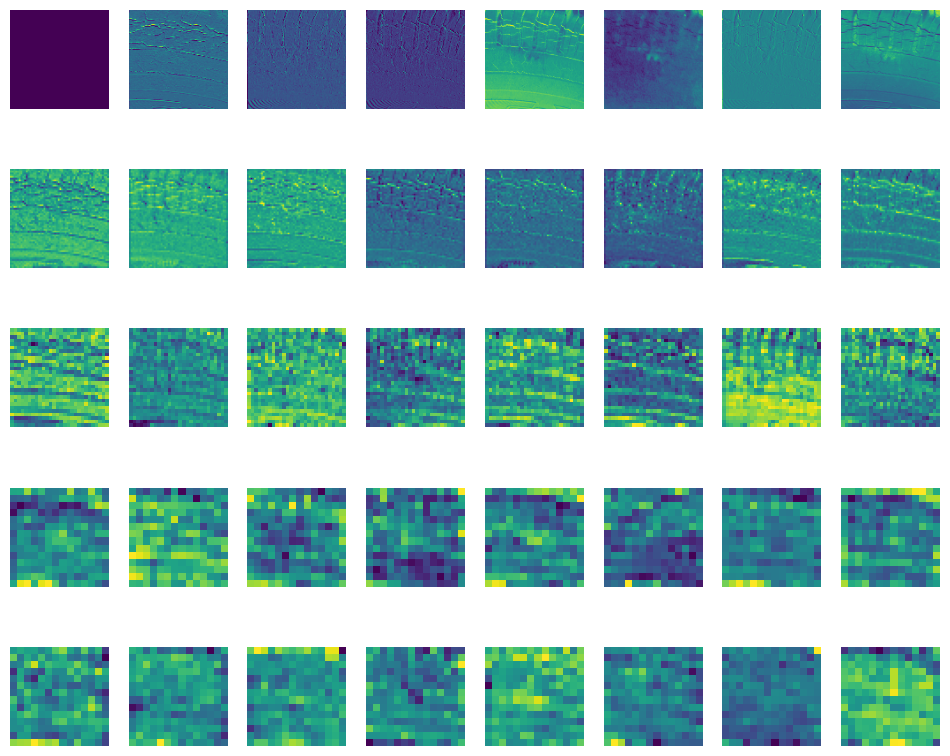

In [24]:
import torch
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image

# Load the pretrained MobileNet model
model = models.mobilenet_v2(pretrained=True)

# Function to visualize feature maps at specific layers in MobileNet
def visualize_feature_maps(model, image, layers=[0, 2, 4, 7, 11]):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    image = image.to(device).unsqueeze(0)  # Add batch dimension

    # Hook function to capture the output of each layer
    activations = {}

    def hook_fn(module, input, output):
        activations[module] = output

    # Register hooks on specified layers
    hooks = []
    for layer_idx in layers:
        hook = model.features[layer_idx].register_forward_hook(hook_fn)
        hooks.append(hook)

    # Forward pass through the model
    with torch.no_grad():
        model(image)

    # Visualize the captured feature maps
    fig, axes = plt.subplots(len(layers), 8, figsize=(12, len(layers) * 2))
    for idx, layer_idx in enumerate(layers):
        layer_output = activations[model.features[layer_idx]]

        # Visualize the first 8 feature maps of the current layer
        for i in range(8):
            ax = axes[idx, i]
            feature_map = layer_output[0, i].detach().cpu().numpy()
            ax.imshow(feature_map, cmap='viridis')
            ax.axis('off')
        axes[idx, 0].set_ylabel(f'Layer {layer_idx}')

    # Remove the hooks
    for hook in hooks:
        hook.remove()

    plt.show()

# Define image transformation (resize, convert to tensor, normalize)
def image_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


img_tensor = image_transform()(img)  # Ensure your image is preprocessed

# Visualize feature maps using MobileNet
visualize_feature_maps(model, img_tensor)


In [25]:
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, log_loss, f1_score, roc_auc_score,
    precision_score, recall_score
)
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Load features (assuming saved and loaded from files)
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')

# Train an SVM classifier with probability estimates enabled
svm = SVC(probability=True)
svm.fit(train_features, train_labels)

# Predict probabilities and class labels for validation features
val_predictions = svm.predict(val_features)
val_pred_proba = svm.predict_proba(val_features)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with SVM: {accuracy * 100:.2f}%")

# Calculate Log Loss
loss = log_loss(val_labels, val_pred_proba)
print(f"SVM Classification Log Loss: {loss:.4f}")

# Calculate F1 Score
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"SVM Classification F1 Score: {f1:.2f}")

# Calculate AUC Score
if len(set(val_labels)) > 2:
    lb = LabelBinarizer()
    val_labels_binarized = lb.fit_transform(val_labels)
    auc = roc_auc_score(val_labels_binarized, val_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(val_labels, val_pred_proba[:, 1])
print(f"SVM Classification AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
print(f"SVM Classification Precision: {precision:.2f}")
print(f"SVM Classification Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")

Validation Accuracy with SVM: 95.64%
SVM Classification Log Loss: 0.1126
SVM Classification F1 Score: 0.96
SVM Classification AUC: 0.99
SVM Classification Precision: 0.96
SVM Classification Recall: 0.96
Metric         : Value
Accuracy       : 95.64%
F1 Score       : 0.96
AUC            : 0.99
Log Loss       : 0.1126
Precision      : 0.96
Recall         : 0.96


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, f1_score, roc_auc_score,
    precision_score, recall_score
)
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Load features (assuming saved and loaded from files)
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')

# Train a RandomForestClassifier with probability estimates enabled
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(train_features, train_labels)

# Predict probabilities and class labels for validation features
val_predictions = rf_classifier.predict(val_features)
val_pred_proba = rf_classifier.predict_proba(val_features)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with Random Forest: {accuracy * 100:.2f}%")

# Calculate Log Loss
loss = log_loss(val_labels, val_pred_proba)
print(f"Random Forest Classification Log Loss: {loss:.4f}")

# Calculate F1 Score
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"Random Forest Classification F1 Score: {f1:.2f}")

# Calculate AUC Score
if len(set(val_labels)) > 2:
    lb = LabelBinarizer()
    val_labels_binarized = lb.fit_transform(val_labels)
    auc = roc_auc_score(val_labels_binarized, val_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(val_labels, val_pred_proba[:, 1])
print(f"Random Forest Classification AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
print(f"Random Forest Classification Precision: {precision:.2f}")
print(f"Random Forest Classification Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")


Validation Accuracy with Random Forest: 92.31%
Random Forest Classification Log Loss: 0.3407
Random Forest Classification F1 Score: 0.92
Random Forest Classification AUC: 0.97
Random Forest Classification Precision: 0.92
Random Forest Classification Recall: 0.92
Metric         : Value
Accuracy       : 92.31%
F1 Score       : 0.92
AUC            : 0.97
Log Loss       : 0.3407
Precision      : 0.92
Recall         : 0.92


In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, f1_score, roc_auc_score,
    precision_score, recall_score
)
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Load features (assuming saved and loaded from files)
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')

# Train a KNeighborsClassifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(train_features, train_labels)

# Predict class labels for validation features
val_predictions = knn_classifier.predict(val_features)

# Check if predict_proba is available (only if `n_neighbors` > 1 and the classifier is suitable)
if hasattr(knn_classifier, "predict_proba"):
    val_pred_proba = knn_classifier.predict_proba(val_features)
    # Calculate Log Loss
    loss = log_loss(val_labels, val_pred_proba)
    print(f"KNN Classification Log Loss: {loss:.4f}")
else:
    val_pred_proba = None
    loss = None
    print("Log Loss not available for KNN without probability estimates.")

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with KNN: {accuracy * 100:.2f}%")

# Calculate F1 Score
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"KNN Classification F1 Score: {f1:.2f}")

# Calculate AUC Score (only if probabilities are available)
if val_pred_proba is not None:
    if len(set(val_labels)) > 2:
        lb = LabelBinarizer()
        val_labels_binarized = lb.fit_transform(val_labels)
        auc = roc_auc_score(val_labels_binarized, val_pred_proba, average="weighted", multi_class="ovr")
    else:
        auc = roc_auc_score(val_labels, val_pred_proba[:, 1])
    print(f"KNN Classification AUC: {auc:.2f}")
else:
    auc = None
    print("AUC not available for KNN without probability estimates.")

# Calculate Precision and Recall
precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
print(f"KNN Classification Precision: {precision:.2f}")
print(f"KNN Classification Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = [
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["Log Loss", f"{loss:.4f}" if loss is not None else "N/A"],
    ["AUC", f"{auc:.2f}" if auc is not None else "N/A"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
]

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")


KNN Classification Log Loss: 0.8475
Validation Accuracy with KNN: 86.92%
KNN Classification F1 Score: 0.87
KNN Classification AUC: 0.96
KNN Classification Precision: 0.89
KNN Classification Recall: 0.87
Metric         : Value
Accuracy       : 86.92%
F1 Score       : 0.87
Log Loss       : 0.8475
AUC            : 0.96
Precision      : 0.89
Recall         : 0.87


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, f1_score, roc_auc_score,
    precision_score, recall_score
)
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Load features (assuming saved and loaded from files)
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')

# Train an XGBClassifier
xgb_classifier = XGBClassifier(eval_metric="logloss", random_state=42)
xgb_classifier.fit(train_features, train_labels)

# Predict probabilities and class labels for validation features
val_predictions = xgb_classifier.predict(val_features)
val_pred_proba = xgb_classifier.predict_proba(val_features)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with XGBoost: {accuracy * 100:.2f}%")

# Calculate Log Loss
loss = log_loss(val_labels, val_pred_proba)
print(f"XGBoost Classification Log Loss: {loss:.4f}")

# Calculate F1 Score
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"XGBoost Classification F1 Score: {f1:.2f}")

# Calculate AUC Score
if len(set(val_labels)) > 2:
    lb = LabelBinarizer()
    val_labels_binarized = lb.fit_transform(val_labels)
    auc = roc_auc_score(val_labels_binarized, val_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(val_labels, val_pred_proba[:, 1])
print(f"XGBoost Classification AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
print(f"XGBoost Classification Precision: {precision:.2f}")
print(f"XGBoost Classification Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")


In [1]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, log_loss, f1_score, roc_auc_score,
    precision_score, recall_score
)
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Load features (assuming saved and loaded from files)
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')

# Train a GaussianNB classifier
gnb_classifier = GaussianNB()
gnb_classifier.fit(train_features, train_labels)

# Predict probabilities and class labels for validation features
val_predictions = gnb_classifier.predict(val_features)
val_pred_proba = gnb_classifier.predict_proba(val_features)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with GaussianNB: {accuracy * 100:.2f}%")

# Calculate Log Loss
loss = log_loss(val_labels, val_pred_proba)
print(f"GaussianNB Classification Log Loss: {loss:.4f}")

# Calculate F1 Score
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"GaussianNB Classification F1 Score: {f1:.2f}")

# Calculate AUC Score
if len(set(val_labels)) > 2:
    lb = LabelBinarizer()
    val_labels_binarized = lb.fit_transform(val_labels)
    auc = roc_auc_score(val_labels_binarized, val_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(val_labels, val_pred_proba[:, 1])
print(f"GaussianNB Classification AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
print(f"GaussianNB Classification Precision: {precision:.2f}")
print(f"GaussianNB Classification Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")


Validation Accuracy with GaussianNB: 86.41%
GaussianNB Classification Log Loss: 4.7291
GaussianNB Classification F1 Score: 0.86
GaussianNB Classification AUC: 0.88
GaussianNB Classification Precision: 0.87
GaussianNB Classification Recall: 0.86
Metric         : Value
Accuracy       : 86.41%
F1 Score       : 0.86
AUC            : 0.88
Log Loss       : 4.7291
Precision      : 0.87
Recall         : 0.86


In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, f1_score, roc_auc_score,
    precision_score, recall_score
)
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Load features (assuming saved and loaded from files)
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')

# Train an MLPClassifier with probability estimates enabled
mlp_classifier = MLPClassifier(random_state=42, max_iter=300)
mlp_classifier.fit(train_features, train_labels)

# Predict probabilities and class labels for validation features
val_predictions = mlp_classifier.predict(val_features)
val_pred_proba = mlp_classifier.predict_proba(val_features)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with MLP: {accuracy * 100:.2f}%")

# Calculate Log Loss
loss = log_loss(val_labels, val_pred_proba)
print(f"MLP Classification Log Loss: {loss:.4f}")

# Calculate F1 Score
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"MLP Classification F1 Score: {f1:.2f}")

# Calculate AUC Score
if len(set(val_labels)) > 2:
    lb = LabelBinarizer()
    val_labels_binarized = lb.fit_transform(val_labels)
    auc = roc_auc_score(val_labels_binarized, val_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(val_labels, val_pred_proba[:, 1])
print(f"MLP Classification AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
print(f"MLP Classification Precision: {precision:.2f}")
print(f"MLP Classification Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")


Validation Accuracy with MLP: 95.64%
MLP Classification Log Loss: 0.1559
MLP Classification F1 Score: 0.96
MLP Classification AUC: 0.99
MLP Classification Precision: 0.96
MLP Classification Recall: 0.96
Metric         : Value
Accuracy       : 95.64%
F1 Score       : 0.96
AUC            : 0.99
Log Loss       : 0.1559
Precision      : 0.96
Recall         : 0.96
